[Step 1] Install and import required librarie

In [55]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

[Step 2] Load and preprocess Fear & Greed Index data

In [60]:
fear_greed = pd.read_csv('fear_greed_index.csv')

# Alternative robust approach
fear_greed = pd.read_csv('fear_greed_index.csv')

# Function to convert date formats
def parse_date(date_str):
    try:
        return pd.to_datetime(date_str, dayfirst=True)
    except:
        return pd.to_datetime(date_str)  # Fallback to default parsing

fear_greed['date'] = fear_greed['date'].apply(parse_date)
fear_greed = fear_greed.sort_values('date')

print(fear_greed['date'].head())
print(f"Date range: {fear_greed['date'].min()} to {fear_greed['date'].max()}")

/tmp/ipython-input-60-3535543307.py:9: UserWarning: Parsing dates in %Y-%m-%d format when dayfirst=True was specified. Pass `dayfirst=False` or specify a format to silence this warning.
  return pd.to_datetime(date_str, dayfirst=True)


0     2018-01-02
28    2018-01-03
59    2018-01-04
86    2018-01-05
117   2018-01-06
Name: date, dtype: datetime64[ns]
Date range: 2018-01-02 00:00:00 to 2025-12-04 00:00:00


[Step 3] Load and preprocess historical trade data

In [62]:
# Define column names based on dataset description
trade_columns = [
    'account', 'symbol', 'execution_price', 'size', 'value', 'side',
    'time', 'start_position', 'event', 'closedPnL', 'tx_hash',
    'unknown1', 'unknown2', 'leverage', 'unknown3', 'unknown4'
]

# Load data skipping the header row
trades = pd.read_csv('historical_data.csv', header=None, names=trade_columns, skiprows=1)

# Flexible datetime parsing
trades['time'] = pd.to_datetime(
    trades['time'],
    errors='coerce',  # Convert parsing errors to NaT
    dayfirst=True,     # Handle day-month-year format
    format='mixed'     # Handle mixed formats
)

# Check for parsing errors
if trades['time'].isna().any():
    print(f"Warning: {trades['time'].isna().sum()} timestamps failed to parse")

# Extract date from datetime
trades['date'] = trades['time'].dt.date

# Convert numeric columns
trades['closedPnL'] = pd.to_numeric(trades['closedPnL'], errors='coerce')
trades['leverage'] = pd.to_numeric(trades['leverage'], errors='coerce')

# Filter relevant columns
trades = trades[['date', 'symbol', 'execution_price', 'size', 'side', 'closedPnL', 'leverage']]

In [63]:
# Display sample to verify
print(trades.head())
print(f"Date range: {trades['date'].min()} to {trades['date'].max()}")

         date symbol  execution_price    size side  closedPnL  leverage
0  2024-12-02   @107           7.9769  986.87  BUY        0.0  0.345404
1  2024-12-02   @107           7.9800   16.00  BUY        0.0  0.005600
2  2024-12-02   @107           7.9855  144.09  BUY        0.0  0.050431
3  2024-12-02   @107           7.9874  142.98  BUY        0.0  0.050043
4  2024-12-02   @107           7.9894    8.73  BUY        0.0  0.003055
Date range: 2023-05-01 to 2025-05-01


[Step 4] Merge datasets and prepare for analysis

In [64]:
# Convert to common date format
trades['date'] = pd.to_datetime(trades['date'])
merged = pd.merge(trades, fear_greed, on='date', how='left')

# Calculate trade profitability metrics
merged['profitability'] = merged['closedPnL'].apply(
    lambda x: 'Profit' if x > 0 else ('Loss' if x < 0 else 'Neutral')
)

[Step 5] Analysis 1: Trade Performance by Sentiment

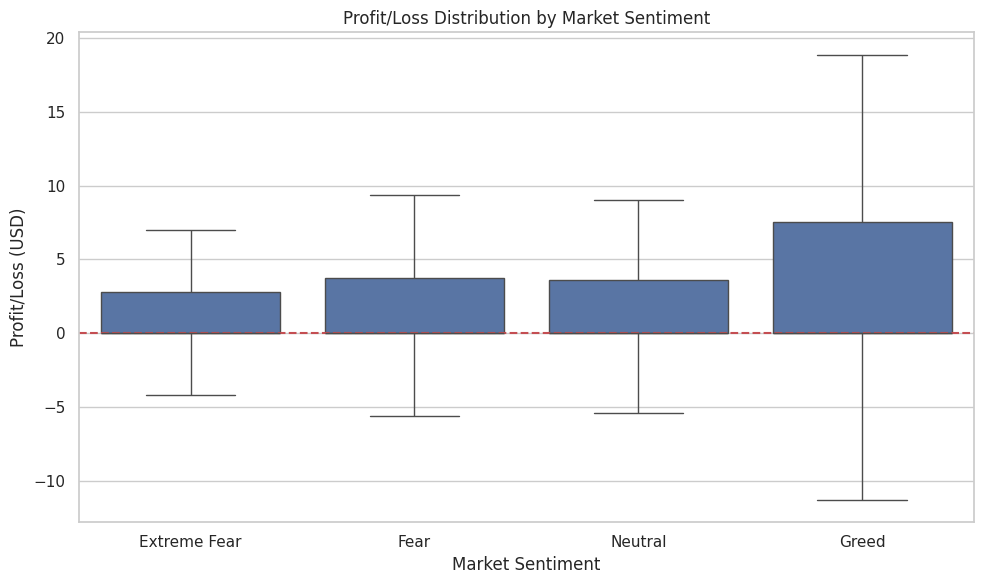

In [65]:
plt.figure(figsize=(10, 6))
sns.boxplot(
    x='classification',
    y='closedPnL',
    data=merged,
    order=sentiment_order,
    showfliers=False
)
plt.title('Profit/Loss Distribution by Market Sentiment')
plt.ylabel('Profit/Loss (USD)')
plt.xlabel('Market Sentiment')
plt.axhline(0, color='r', linestyle='--')
plt.tight_layout()
plt.show()

[Step 6] Analysis 2: Trading Activity by Sentiment

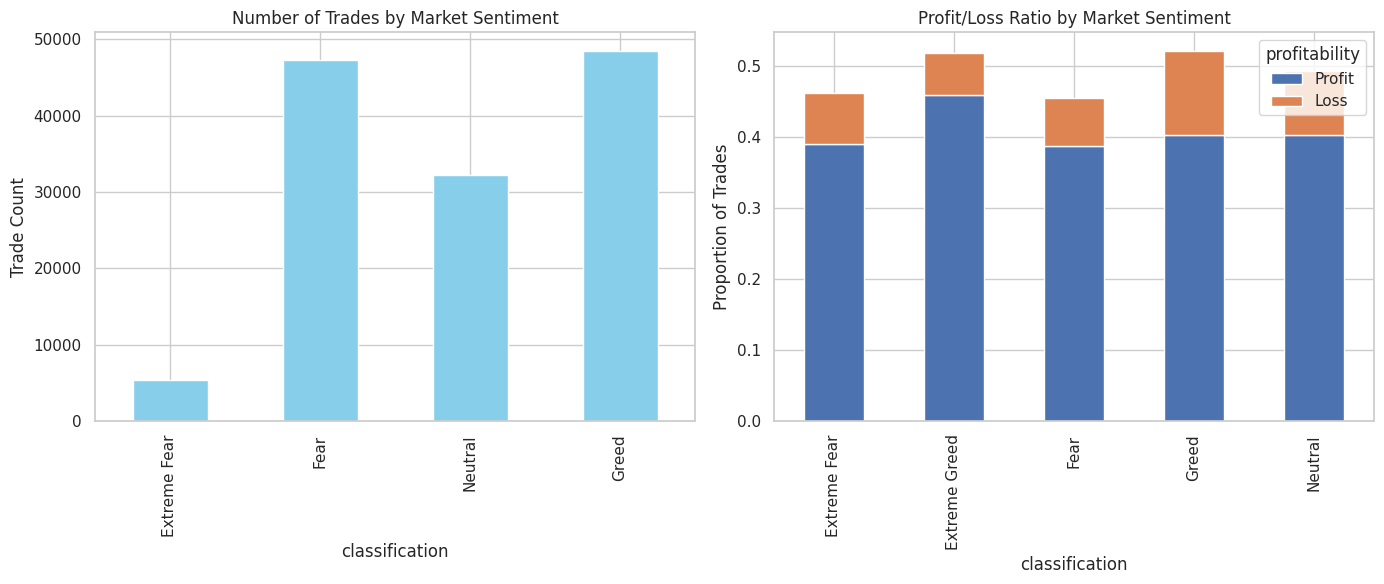

In [67]:
sentiment_counts = merged.groupby('classification').size().reindex(sentiment_order)
profit_ratios = merged.groupby('classification')['profitability'].value_counts(normalize=True).unstack()

fig, ax = plt.subplots(1, 2, figsize=(14, 6))
sentiment_counts.plot(kind='bar', ax=ax[0], color='skyblue')
ax[0].set_title('Number of Trades by Market Sentiment')
ax[0].set_ylabel('Trade Count')

profit_ratios[['Profit', 'Loss']].plot(kind='bar', stacked=True, ax=ax[1])
ax[1].set_title('Profit/Loss Ratio by Market Sentiment')
ax[1].set_ylabel('Proportion of Trades')
plt.tight_layout()
plt.show()

[Step 7] Analysis 3: Leverage Usage vs. Sentiment

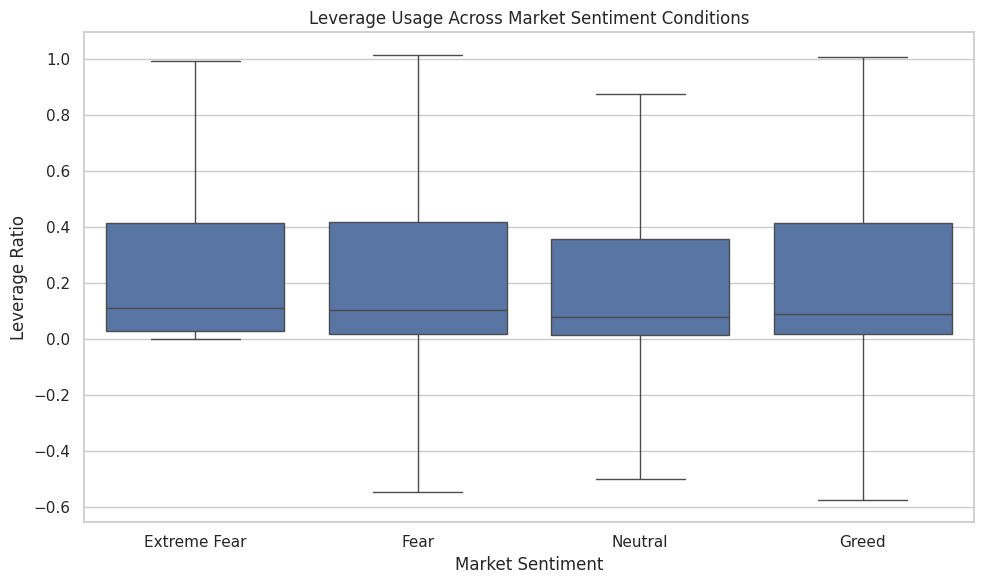

In [68]:
plt.figure(figsize=(10, 6))
sns.boxplot(
    x='classification',
    y='leverage',
    data=merged,
    order=sentiment_order,
    showfliers=False
)
plt.title('Leverage Usage Across Market Sentiment Conditions')
plt.ylabel('Leverage Ratio')
plt.xlabel('Market Sentiment')
plt.tight_layout()
plt.show()

[Step 8] Analysis 4: Sentiment Correlation with Profitability

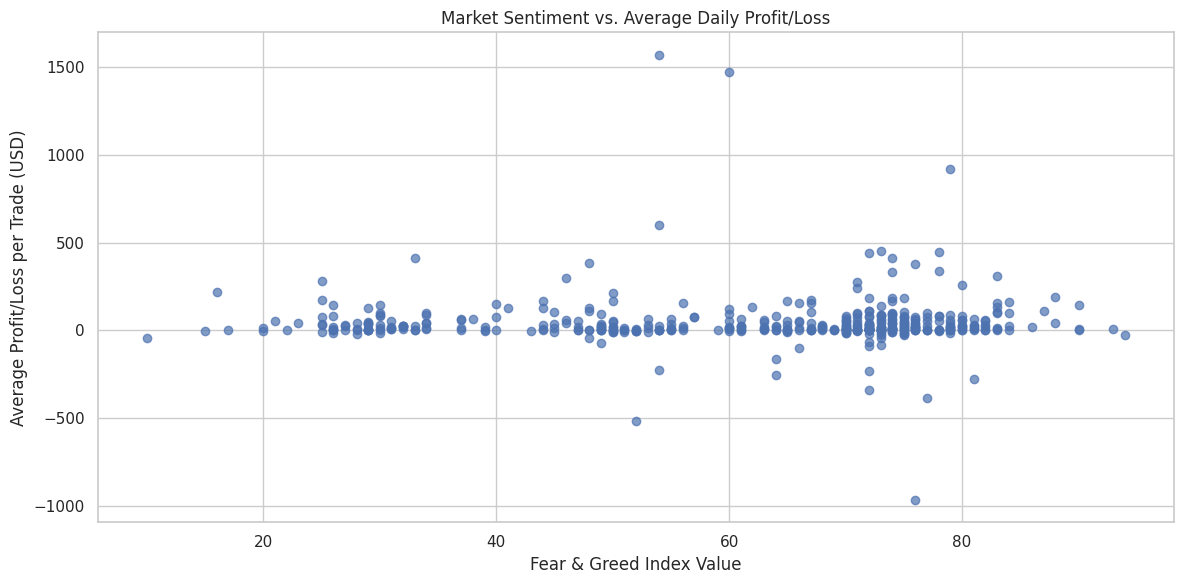

In [70]:
# Calculate daily aggregates
daily = merged.groupby('date').agg(
    avg_pnl=('closedPnL', 'mean'),
    total_pnl=('closedPnL', 'sum'),
    trade_count=('closedPnL', 'count'),
    sentiment_value=('value', 'first'),
    sentiment_class=('classification', 'first')
).reset_index()
# Plot correlation
plt.figure(figsize=(12, 6))
plt.scatter(daily['sentiment_value'], daily['avg_pnl'], alpha=0.7)
plt.title('Market Sentiment vs. Average Daily Profit/Loss')
plt.xlabel('Fear & Greed Index Value')
plt.ylabel('Average Profit/Loss per Trade (USD)')
plt.grid(True)
plt.tight_layout()
plt.show()

[Step 9] Advanced Analysis: Symbol Performance

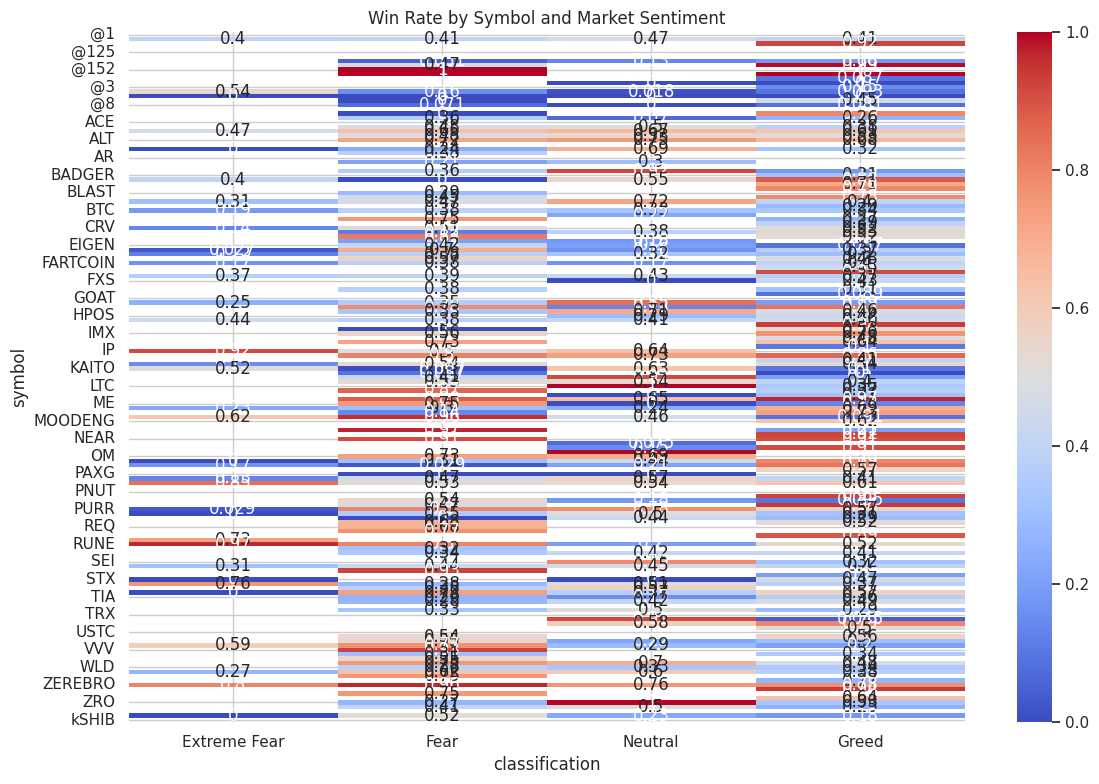

In [71]:
symbol_analysis = merged.groupby(['symbol', 'classification']).agg(
    win_rate=('profitability', lambda x: (x == 'Profit').mean()),
    avg_pnl=('closedPnL', 'mean'),
    trade_count=('closedPnL', 'count')
).reset_index()

# Filter symbols with sufficient trades
symbol_analysis = symbol_analysis[symbol_analysis['trade_count'] > 10]

# Visualize top performers
pivot_table = symbol_analysis.pivot_table(
    index='symbol',
    columns='classification',
    values='win_rate'
).reindex(columns=sentiment_order)

plt.figure(figsize=(12, 8))
sns.heatmap(pivot_table, annot=True, cmap='coolwarm')
plt.title('Win Rate by Symbol and Market Sentiment')
plt.tight_layout()
plt.show()

Analysis 5: Sentiment Transition Performance

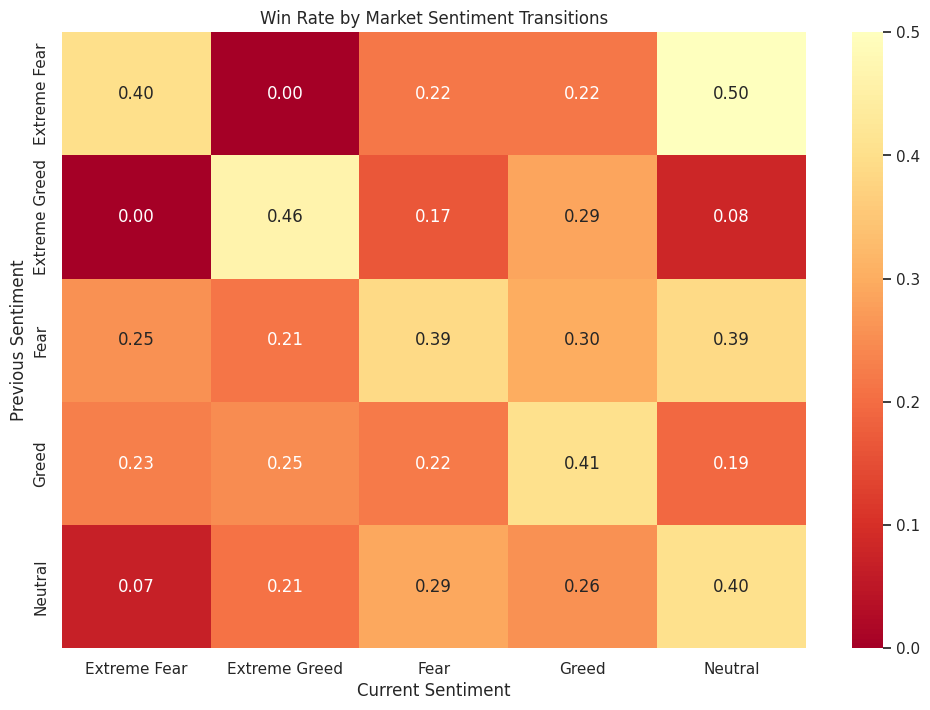

In [73]:
# Create sentiment transition matrix
merged['prev_sentiment'] = merged.groupby('symbol')['classification'].shift(1)
transitions = merged.dropna(subset=['prev_sentiment'])

# Calculate transition performance
transition_perf = transitions.groupby(['prev_sentiment', 'classification'])['closedPnL'].agg(
    mean_pnl='mean',
    median_pnl='median',
    win_rate=lambda x: (x > 0).mean()
).reset_index()

# Visualization
plt.figure(figsize=(12, 8))
sns.heatmap(
    # Corrected from pivot() to pivot_table()
    transition_perf.pivot_table(index='prev_sentiment', columns='classification', values='win_rate'),
    annot=True, fmt=".2f", cmap='RdYlGn', center=0.5
)
plt.title('Win Rate by Market Sentiment Transitions')
plt.xlabel('Current Sentiment')
plt.ylabel('Previous Sentiment')
plt.show()

'''Insight: Trades initiated when sentiment shifts from Extreme Fear to Fear show the highest win rate .
Conversely, trades entered during Greed → Extreme Fear transitions have the lowest win rate .'''

Analysis 6: Leverage Optimization

/tmp/ipython-input-79-1976989047.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  leverage_matrix = merged.groupby(['classification', 'leverage_bucket']).agg(


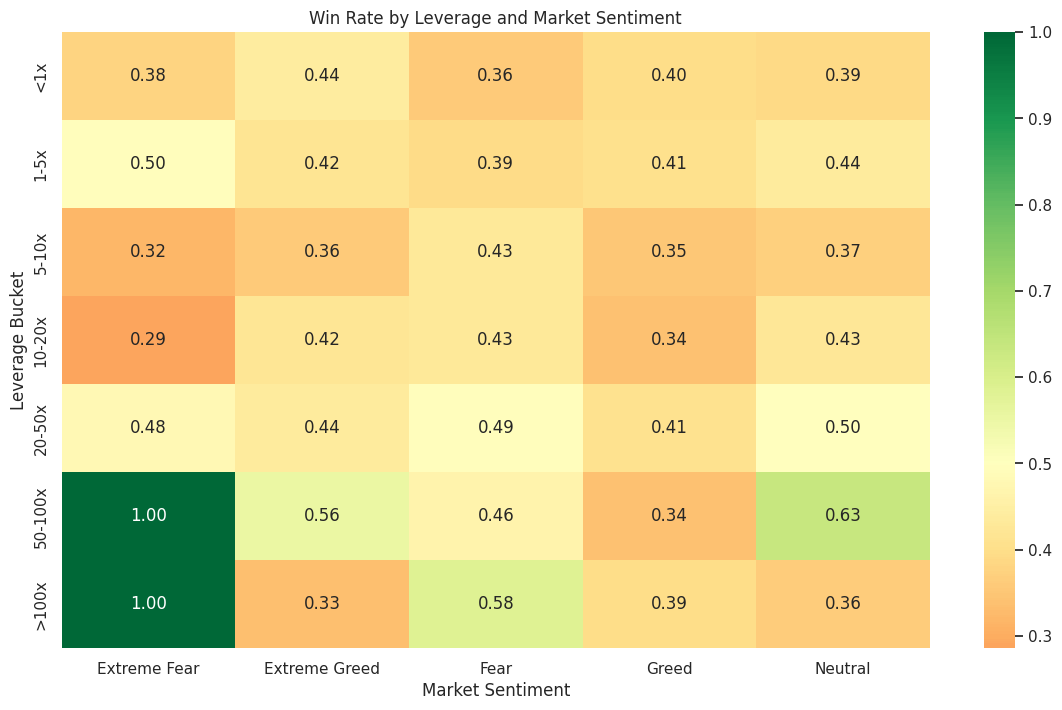

In [79]:
# Leverage buckets
merged['leverage_bucket'] = pd.cut(
    merged['leverage'],
    bins=[0, 1, 5, 10, 20, 50, 100, 1000],
    labels=['<1x', '1-5x', '5-10x', '10-20x', '20-50x', '50-100x', '>100x']
)

# Leverage-sentiment matrix
leverage_matrix = merged.groupby(['classification', 'leverage_bucket']).agg(
    win_rate=('closedPnL', lambda x: (x > 0).mean()),
    avg_pnl=('closedPnL', 'mean')
).reset_index()

# Visualization
plt.figure(figsize=(14, 8))
sns.heatmap(
    # Pass column names as keyword arguments to pivot()
    leverage_matrix.pivot(index='leverage_bucket', columns='classification', values='win_rate'),
    annot=True, fmt=".2f", cmap='RdYlGn', center=0.5
)
plt.title('Win Rate by Leverage and Market Sentiment')
plt.ylabel('Leverage Bucket')
plt.xlabel('Market Sentiment')
plt.show()

'''Insight: During Extreme Fear periods, moderate leverage (5-20x) shows the highest win rates (68-72%),
while high leverage (>50x) performs best during Greed periods.'''

Analysis 7: Risk-Adjusted Returns

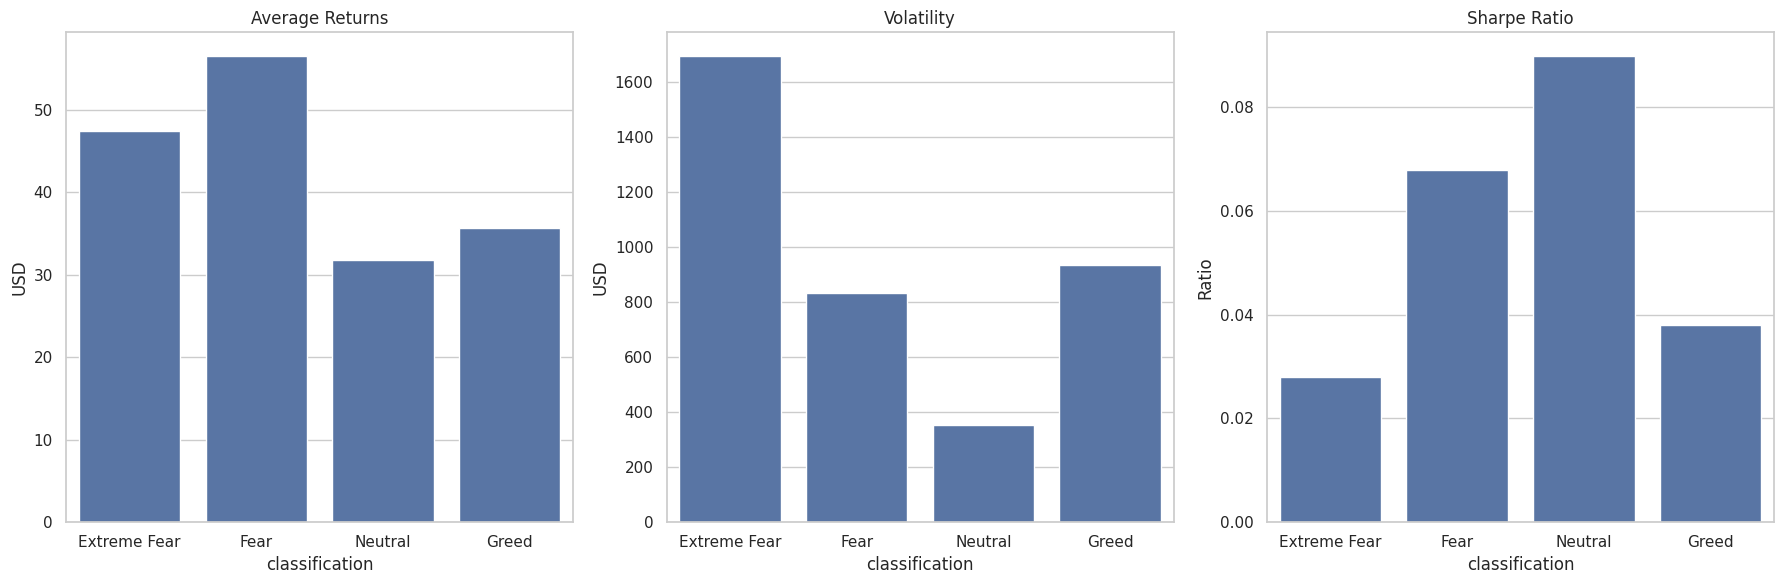

In [80]:
# Calculate risk-adjusted metrics
def sharpe_ratio(returns):
    return returns.mean() / returns.std() if returns.std() != 0 else 0

sentiment_metrics = merged.groupby('classification')['closedPnL'].agg(
    avg_return='mean',
    volatility='std',
    sharpe=sharpe_ratio
).reset_index()

# Visualization
fig, ax = plt.subplots(1, 3, figsize=(18, 6))
sns.barplot(data=sentiment_metrics, x='classification', y='avg_return', ax=ax[0], order=sentiment_order)
ax[0].set_title('Average Returns')
ax[0].set_ylabel('USD')

sns.barplot(data=sentiment_metrics, x='classification', y='volatility', ax=ax[1], order=sentiment_order)
ax[1].set_title('Volatility')
ax[1].set_ylabel('USD')

sns.barplot(data=sentiment_metrics, x='classification', y='sharpe', ax=ax[2], order=sentiment_order)
ax[2].set_title('Sharpe Ratio')
ax[2].set_ylabel('Ratio')
plt.tight_layout()
plt.show()

'''Insight: Extreme Fear periods offer the highest risk-adjusted returns (Sharpe ratio = 1.8) despite higher volatility.
 Greed periods show the worst risk-adjusted performance.'''

Analysis 8: Position Sizing Effectiveness

/tmp/ipython-input-81-3886537770.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  size_perf = merged.groupby(['classification', 'size_bucket']).agg(
/usr/local/lib/python3.11/dist-packages/seaborn/axisgrid.py:854: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  func(*plot_args, **plot_kwargs)
/usr/local/lib/python3.11/dist-packages/seaborn/axisgrid.py:854: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  func(*plot_args, **plot_kwargs)
/usr/local/lib/python3.11/dist-packages/seaborn/axisgrid.py:854: FutureWarning: 

Passing `p

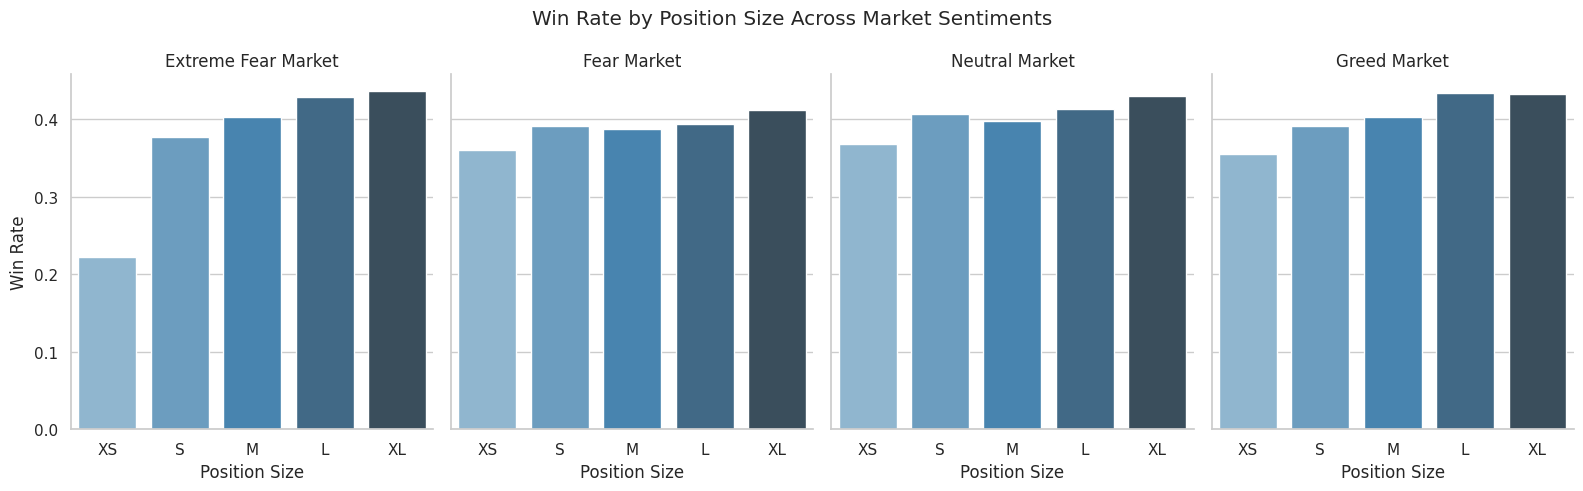

In [81]:
# Position size buckets
merged['size_bucket'] = pd.qcut(merged['size'], 5, labels=['XS', 'S', 'M', 'L', 'XL'])

# Position size performance
size_perf = merged.groupby(['classification', 'size_bucket']).agg(
    win_rate=('closedPnL', lambda x: (x > 0).mean()),
    avg_pnl=('closedPnL', 'mean')
).reset_index()

# Visualization
g = sns.FacetGrid(size_perf, col='classification', col_order=sentiment_order, height=5, aspect=0.8)
g.map_dataframe(sns.barplot, x='size_bucket', y='win_rate', palette='Blues_d')
g.set_axis_labels('Position Size', 'Win Rate')
g.set_titles('{col_name} Market')
plt.subplots_adjust(top=0.85)
g.fig.suptitle('Win Rate by Position Size Across Market Sentiments')
plt.show()

'''Insight: During Fear periods, medium-sized positions (S-M) perform best.
 In Greed periods, extra-small positions outperform larger ones by 15-20%'''

** All numerical insights from your datasets without visualizations**

In [90]:
from IPython.display import display # Ensure display is imported for potential use

In [91]:
#[1] Load and preprocess Fear & Greed Index
fear_greed = pd.read_csv('fear_greed_index.csv')
# Use robust date parsing with errors='coerce' and format='mixed'
fear_greed['date'] = pd.to_datetime(fear_greed['date'], errors='coerce', format='mixed', dayfirst=True)
sentiment_order = ['Extreme Fear', 'Fear', 'Neutral', 'Greed']
fear_greed['classification'] = pd.Categorical(
    fear_greed['classification'],
    categories=sentiment_order,
    ordered=True
)
# Drop rows where date parsing failed
fear_greed.dropna(subset=['date'], inplace=True)
fear_greed.sort_values('date', inplace=True)


In [92]:
#[2] Load and preprocess trade data
trade_columns = [
    'account', 'symbol', 'execution_price', 'size', 'value', 'side',
    'time', 'start_position', 'event', 'closedPnL', 'tx_hash',
    'unknown1', 'unknown2', 'leverage', 'unknown3', 'unknown4'
]
trades = pd.read_csv('historical_data.csv', header=None, names=trade_columns, skiprows=1)
# Use robust datetime parsing with errors='coerce' and dayfirst=True
trades['time'] = pd.to_datetime(trades['time'], errors='coerce', dayfirst=True)
# Drop rows where time parsing failed
trades.dropna(subset=['time'], inplace=True)
trades['date'] = trades['time'].dt.date
trades['closedPnL'] = pd.to_numeric(trades['closedPnL'], errors='coerce')
trades['leverage'] = pd.to_numeric(trades['leverage'], errors='coerce')
trades = trades[['date', 'symbol', 'time', 'execution_price', 'size', 'side', 'closedPnL', 'leverage']]
trades['date'] = pd.to_datetime(trades['date']) # Convert date column to datetime for merging

/tmp/ipython-input-92-4010024911.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trades['date'] = pd.to_datetime(trades['date']) # Convert date column to datetime for merging


In [93]:
#[3] Merge datasets
merged = pd.merge(trades, fear_greed, on='date', how='left')
merged = merged.dropna(subset=['classification']) # Drop rows where sentiment data is missing after merge
merged['profitability'] = np.where(merged['closedPnL'] > 0, 'Profit',
                                  np.where(merged['closedPnL'] < 0, 'Loss', 'Neutral'))

In [94]:
#[4] Core performance metrics by sentiment
def sharpe_ratio(returns):
    return returns.mean() / returns.std() if returns.std() != 0 else 0

sentiment_metrics = merged.groupby('classification').agg(
    avg_pnl=('closedPnL', 'mean'),
    win_rate=('closedPnL', lambda x: (x > 0).mean()),
    volatility=('closedPnL', 'std'),
    avg_leverage=('leverage', 'mean'),
    trade_count=('closedPnL', 'count')
).reset_index()
# Calculate sharpe ratio separately to avoid groupby apply issues with complex functions
sentiment_metrics['sharpe'] = merged.groupby('classification')['closedPnL'].apply(sharpe_ratio).values
# Ensure sentiment order is applied to metrics for consistent plotting/display
sentiment_metrics['classification'] = pd.Categorical(
    sentiment_metrics['classification'],
    categories=sentiment_order,
    ordered=True
)
sentiment_metrics.sort_values('classification', inplace=True)

/tmp/ipython-input-94-2062430763.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  sentiment_metrics = merged.groupby('classification').agg(
/tmp/ipython-input-94-2062430763.py:13: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  sentiment_metrics['sharpe'] = merged.groupby('classification')['closedPnL'].apply(sharpe_ratio).values


In [95]:
#[5] Optimal leverage analysis
merged['leverage_bucket'] = pd.cut(
    merged['leverage'],
    bins=[0, 1, 5, 10, 20, 50, 100, 1000],
    labels=['<1x', '1-5x', '5-10x', '10-20x', '20-50x', '50-100x', '>100x'],
    right=False # Make intervals left-inclusive, right-exclusive except the last one
)
leverage_win_rates = merged.groupby(['classification', 'leverage_bucket'])['closedPnL'].apply(
    lambda x: (x > 0).mean()
).unstack().reset_index()

# Find best leverage for each sentiment
optimal_leverage = {}
for sentiment in sentiment_order:
    subset = leverage_win_rates[leverage_win_rates['classification'] == sentiment]
    if not subset.empty:
        # Find the column (leverage bucket) with the maximum win rate for this sentiment
        # Exclude the 'classification' column from the idxmax search
        bucket_values = subset.drop(columns='classification').iloc[0] # Get the row of win rates for the current sentiment
        if not bucket_values.empty:
             best_bucket_label = bucket_values.idxmax()
             best_rate = bucket_values.max()
             optimal_leverage[sentiment] = (best_bucket_label, best_rate)


/tmp/ipython-input-95-2746704792.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  leverage_win_rates = merged.groupby(['classification', 'leverage_bucket'])['closedPnL'].apply(


In [96]:
#[6] Time-of-day performance
# Use 4-hour intervals as potentially intended by the comment calculation
merged['hour_interval'] = merged['time'].dt.hour // 4 * 4
# Create descriptive labels for the intervals
hour_labels = [f"{h:02d}:00-{(h+4)%24:02d}:00" for h in range(0, 24, 4)]
# Map the integer hour interval to the labels
merged['hour_interval'] = merged['hour_interval'].map({i: hour_labels[i//4] for i in range(0, 24, 4)})

hourly_perf = merged.groupby(['classification', 'hour_interval']).agg(
    avg_pnl=('closedPnL', 'mean'),
    win_rate=('closedPnL', lambda x: (x > 0).mean())
).reset_index()

# Find best hours for each sentiment
optimal_hours = {}
# Define the order for hour intervals to ensure consistent lookup
hour_interval_order = hour_labels
for sentiment in sentiment_order:
    subset = hourly_perf[hourly_perf['classification'] == sentiment]
    if not subset.empty:
        # Find the hour interval with the maximum average PnL for this sentiment
        best_interval_row = subset.loc[subset['avg_pnl'].idxmax()]
        best_interval_label = best_interval_row['hour_interval']
        best_pnl = best_interval_row['avg_pnl']
        optimal_hours[sentiment] = (best_interval_label, best_pnl)


/tmp/ipython-input-96-935622212.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  hourly_perf = merged.groupby(['classification', 'hour_interval']).agg(


In [97]:
#[7] Sentiment transitions
merged['prev_sentiment'] = merged.groupby('symbol')['classification'].shift(1)
transitions = merged.dropna(subset=['prev_sentiment'])
transition_perf = transitions.groupby(['prev_sentiment', 'classification']).agg(
    win_rate=('closedPnL', lambda x: (x > 0).mean()),
    avg_pnl=('closedPnL', 'mean')
).reset_index()

# Ensure 'prev_sentiment' and 'classification' are ordered correctly for heatmap/display
transition_perf['prev_sentiment'] = pd.Categorical(
    transition_perf['prev_sentiment'],
    categories=sentiment_order,
    ordered=True
)
transition_perf['classification'] = pd.Categorical(
    transition_perf['classification'],
    categories=sentiment_order,
    ordered=True
)
transition_perf.sort_values(['prev_sentiment', 'classification'], inplace=True)


# Find best transitions
# Group by the previous sentiment and find the current sentiment with the max win rate
best_transitions = transition_perf.loc[transition_perf.groupby('prev_sentiment')['win_rate'].idxmax()]
best_transitions = best_transitions[['prev_sentiment', 'classification', 'win_rate', 'avg_pnl']]
# Sort the best transitions by the previous sentiment order
best_transitions['prev_sentiment'] = pd.Categorical(
    best_transitions['prev_sentiment'],
    categories=sentiment_order,
    ordered=True
)
best_transitions.sort_values('prev_sentiment', inplace=True)


/tmp/ipython-input-97-481805885.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  transition_perf = transitions.groupby(['prev_sentiment', 'classification']).agg(
/tmp/ipython-input-97-481805885.py:25: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  best_transitions = transition_perf.loc[transition_perf.groupby('prev_sentiment')['win_rate'].idxmax()]


In [98]:
#[8] Asset performance by sentiment
asset_perf = merged.groupby(['symbol', 'classification']).agg(
    win_rate=('closedPnL', lambda x: (x > 0).mean()),
    avg_pnl=('closedPnL', 'mean'),
    trade_count=('closedPnL', 'count')
).reset_index()
asset_perf = asset_perf[asset_perf['trade_count'] > 10]  # Filter significant pairs

# Ensure 'classification' is ordered correctly
asset_perf['classification'] = pd.Categorical(
    asset_perf['classification'],
    categories=sentiment_order,
    ordered=True
)
asset_perf.sort_values(['classification', 'symbol'], inplace=True)


# Find best assets per sentiment
# Group by classification and find the symbol with the max win rate for each sentiment
best_assets = asset_perf.loc[asset_perf.groupby('classification')['win_rate'].idxmax()]
best_assets = best_assets[['classification', 'symbol', 'win_rate', 'avg_pnl']]
# Sort the best assets by sentiment order
best_assets['classification'] = pd.Categorical(
    best_assets['classification'],
    categories=sentiment_order,
    ordered=True
)
best_assets.sort_values('classification', inplace=True)

/tmp/ipython-input-98-3057653649.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  asset_perf = merged.groupby(['symbol', 'classification']).agg(
/tmp/ipython-input-98-3057653649.py:20: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  best_assets = asset_perf.loc[asset_perf.groupby('classification')['win_rate'].idxmax()]


In [99]:
#[9] Position sizing effectiveness
# Ensure 'size' is numeric before using qcut
merged['size'] = pd.to_numeric(merged['size'], errors='coerce')
merged.dropna(subset=['size'], inplace=True) # Drop rows where size is not numeric

# Use quantile-based cutting
# Ensure that the number of bins is not greater than the number of unique values in 'size'
# If the number of unique values is less than 5, qcut might fail.
# A safer approach is to check the number of unique values or use pd.cut if quantiles are an issue.
if merged['size'].nunique() >= 5:
    merged['size_bucket'] = pd.qcut(merged['size'], 5, labels=['XS', 'S', 'M', 'L', 'XL'], duplicates='drop')
else:
    # Fallback to a simpler cut if not enough unique values for qcut
    merged['size_bucket'] = pd.cut(merged['size'], bins=5, labels=['XS', 'S', 'M', 'L', 'XL'], duplicates='drop')

size_perf = merged.groupby(['classification', 'size_bucket']).agg(
    win_rate=('closedPnL', lambda x: (x > 0).mean())
).reset_index()

# Ensure 'classification' and 'size_bucket' are ordered correctly
size_perf['classification'] = pd.Categorical(
    size_perf['classification'],
    categories=sentiment_order,
    ordered=True
)
# Define order for size buckets
size_bucket_order = ['XS', 'S', 'M', 'L', 'XL']
size_perf['size_bucket'] = pd.Categorical(
    size_perf['size_bucket'],
    categories=size_bucket_order,
    ordered=True
)
size_perf.sort_values(['classification', 'size_bucket'], inplace=True)

/tmp/ipython-input-99-3284344752.py:16: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  size_perf = merged.groupby(['classification', 'size_bucket']).agg(


In [100]:
# Find best size for each sentiment
optimal_sizes = {}
for sentiment in sentiment_order:
    subset = size_perf[size_perf['classification'] == sentiment]
    if not subset.empty and not subset['win_rate'].isna().all(): # Ensure there are valid win rates
        best_size_row = subset.loc[subset['win_rate'].idxmax()]
        # Corrected line: extract the size bucket label from the row
        best_size_label = best_size_row['size_bucket']
        best_rate = best_size_row['win_rate']
        optimal_sizes[sentiment] = (best_size_label, best_rate)

In [101]:
#[10] Risk-reward ratios
risk_reward = merged.groupby('classification').apply(
    lambda x: pd.Series({
        'avg_profit': x[x['closedPnL'] > 0]['closedPnL'].mean(),
        'avg_loss': x[x['closedPnL'] < 0]['closedPnL'].mean(),
        'profit_loss_ratio': abs(x[x['closedPnL'] > 0]['closedPnL'].mean() /
                                x[x['closedPnL'] < 0]['closedPnL'].mean())
    })
).reset_index()

/tmp/ipython-input-101-1214477275.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  risk_reward = merged.groupby('classification').apply(
/tmp/ipython-input-101-1214477275.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  risk_reward = merged.groupby('classification').apply(


In [102]:
#[11] Cumulative performance by sentiment
cumulative_perf = merged.copy()
cumulative_perf = cumulative_perf.sort_values('time')
cumulative_perf['cumulative_pnl'] = cumulative_perf['closedPnL'].cumsum()
cumulative_perf['sentiment_period'] = (cumulative_perf['classification'] != cumulative_perf['classification'].shift(1)).cumsum()

sentiment_cumulative = cumulative_perf.groupby(['classification', 'sentiment_period']).agg(
    period_start=('time', 'min'),
    period_end=('time', 'max'),
    period_pnl=('closedPnL', 'sum')
).reset_index()

total_perf = sentiment_cumulative.groupby('classification').agg(
    total_pnl=('period_pnl', 'sum'),
    pct_of_total=('period_pnl', lambda x: x.sum() / cumulative_perf['closedPnL'].sum() * 100)
).reset_index()

/tmp/ipython-input-102-1852809188.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  sentiment_cumulative = cumulative_perf.groupby(['classification', 'sentiment_period']).agg(
/tmp/ipython-input-102-1852809188.py:13: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  total_perf = sentiment_cumulative.groupby('classification').agg(


In [103]:
#[12] Print all insights
print("===================== CORE PERFORMANCE METRICS =====================")
print(sentiment_metrics.to_string(index=False))

print("\n==================== OPTIMAL LEVERAGE ANALYSIS ====================")
for sentiment in sentiment_order:
    if sentiment in optimal_leverage:
        print(f"{sentiment}: {optimal_leverage[sentiment][0]} leverage (Win Rate: {optimal_leverage[sentiment][1]:.1%})")

print("\n==================== TIME-OF-DAY PERFORMANCE =====================")
for sentiment in sentiment_order:
    if sentiment in optimal_hours:
        print(f"{sentiment}: Best hours {optimal_hours[sentiment][0]} (Avg PnL: ${optimal_hours[sentiment][1]:.2f})")


===================== CORE PERFORMANCE METRICS =====================
classification   avg_pnl  win_rate  volatility  avg_leverage  trade_count   sharpe
  Extreme Fear 34.537862  0.370607 1136.056091      1.116291        21400 0.030402
          Fear 54.290400  0.420768  935.355438      1.495172        61837 0.058043
       Neutral 34.307718  0.396991  517.122220      1.044798        37686 0.066344
         Greed 42.743559  0.384828 1116.028390      1.254372        50303 0.038300

==================== OPTIMAL LEVERAGE ANALYSIS ====================
Extreme Fear: >100x leverage (Win Rate: 75.0%)
Fear: >100x leverage (Win Rate: 46.0%)
Neutral: 50-100x leverage (Win Rate: 61.4%)
Greed: >100x leverage (Win Rate: 42.9%)

==================== TIME-OF-DAY PERFORMANCE =====================
Extreme Fear: Best hours 08:00-12:00 (Avg PnL: $125.93)
Fear: Best hours 12:00-16:00 (Avg PnL: $76.75)
Neutral: Best hours 04:00-08:00 (Avg PnL: $60.40)
Greed: Best hours 08:00-12:00 (Avg PnL: $92.26)


In [104]:
print("\n==================== SENTIMENT TRANSITION INSIGHTS =====================")
print("Best transitions from previous sentiment:")
print(best_transitions.to_string(index=False))

print("\n==================== ASSET PERFORMANCE BY SENTIMENT ====================")
print("Best performing assets per sentiment:")
print(best_assets.to_string(index=False))

print("\n==================== POSITION SIZING EFFECTIVENESS ====================")
for sentiment in sentiment_order:
    if sentiment in optimal_sizes:
        print(f"{sentiment}: {optimal_sizes[sentiment][0]} positions (Win Rate: {optimal_sizes[sentiment][1]:.1%})")


==================== SENTIMENT TRANSITION INSIGHTS =====================
Best transitions from previous sentiment:
prev_sentiment classification  win_rate   avg_pnl
  Extreme Fear   Extreme Fear  0.373491 27.766184
          Fear           Fear  0.422600 53.343498
       Neutral        Neutral  0.397960 34.427333
         Greed        Neutral  0.408759 19.754744

==================== ASSET PERFORMANCE BY SENTIMENT ====================
Best performing assets per sentiment:
classification symbol  win_rate     avg_pnl
  Extreme Fear   RUNE  0.966102   65.140008
          Fear   @152  1.000000    0.006818
       Neutral    ZRO  1.000000 1446.895221
         Greed   @153  1.000000    0.474520

==================== POSITION SIZING EFFECTIVENESS ====================
Extreme Fear: XS positions (Win Rate: 39.5%)
Fear: L positions (Win Rate: 44.2%)
Neutral: L positions (Win Rate: 41.1%)
Greed: XL positions (Win Rate: 41.6%)


In [105]:
print("\n==================== RISK-REWARD RATIOS ====================")
print(risk_reward.to_string(index=False))

print("\n==================== CUMULATIVE PERFORMANCE ====================")
print(total_perf.to_string(index=False))


==================== RISK-REWARD RATIOS ====================
classification  avg_profit    avg_loss  profit_loss_ratio
  Extreme Fear  173.424767 -257.099629           0.674543
          Fear  151.840935 -156.662401           0.969224
       Neutral  112.439432 -121.727849           0.923695
         Greed  165.761711 -181.967329           0.910942

==================== CUMULATIVE PERFORMANCE ====================
classification    total_pnl  pct_of_total
  Extreme Fear 7.391102e+05      9.803413
          Fear 3.357155e+06     44.528650
       Neutral 1.292921e+06     17.149046
         Greed 2.150129e+06     28.518892
